## Changes in the DLinear 

shuffle_flag = True --> False for tersting 

shuffle_flag = True --> False for training 


model_name=DLinear --> Linear 

In dataloader: Dataset_ETT_hour(scale=True-->False)

AR: Scale->Predict->Unscale->MSE: 
Linear: Scale->Predict->Unscale->MSE: 

AR: Scale->Predict->MSE: 
Linear: Scale->Predict->MSE: 0.375

AR: No scaling-> Predict -> MSE 
Linear: No Scaling -> Predict-> MSE 

Make sure inputs are same. 

In [3]:
seq_len = 336 
border1s = [0, 12 * 30 * 24 - seq_len, 12 * 30 * 24 + 4 * 30 * 24 - seq_len]
border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

In [4]:
border1s, border2s

([0, 8304, 11184], [8640, 11520, 14400])

In [5]:
import torch 
import neuralprophet
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed 
set_log_level("ERROR", "INFO")

import numpy as np
set_random_seed(0)
import pandas as pd
from sklearn.preprocessing import StandardScaler

import copy 

def MSE(g_truth, measured):
    n=len(g_truth)
    diff=g_truth-measured
    return np.sum(np.square(diff)) / n 
    
    

from sklearn.metrics import mean_absolute_percentage_error
def MAPE(g_truth, measured):
    return (mean_absolute_percentage_error(g_truth,measured))

def wMAPE(g_truth, measured):
    nR = np.sum( np.absolute (g_truth-measured ))
    dR = np.sum( np.absolute (g_truth) )
    return (nR/dR)


def getPercentagedataset(N,n=96):
    print ("N, n", N,n)
    return ((n)/N)

def readDataset(csvFilename=""):
    df = pd.read_csv(csvFilename)
    print ("shape of dataset: ", df.shape)
    return df 

def ScaleDataset(df, date, numericalCols ):
    df = copy.deepcopy(df)
    date = copy.deepcopy(date)
    numericalCols = copy.deepcopy(numericalCols)
    scaler = StandardScaler()
    # Fit the scaler to the data
    scaler.fit(df)
    # Transform the data using the scaler
    df = scaler.transform(df)
    df = pd.DataFrame(df)
    #df["date"] = date
    #numericalCols.append("date")
    numericalCols.insert(0,"date")
    print ("date: ", date.shape, "df: ",df.shape)

    df.insert(0,'date', date.tolist())
    print ("columns: " , df.columns)
    #print (df[1:2])
    df = df.set_axis(numericalCols, axis=1, inplace=False)

    return df



def prepareDataFrame(df):
    nrows_=df.shape[0]
    regions = list(df)[1:]
    df_global = pd.DataFrame()
    for col in regions:
        print (col)
        aux = df[["date", col]].copy(deep=True)  # select column associated with region
        aux = aux.iloc[:nrows_, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
        aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
        aux["ID"] = col
        df_global = pd.concat((df_global, aux))


    df_global.rename({"date":"ds"},
                 inplace=True,
                axis=1)
    return df_global

def train_test_split(df_global, nhorizion=96, valid_p_=-1):
    print ("percentage test: ", valid_p_)
    m = NeuralProphet(growth='off',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  n_lags=336,
                  learning_rate=0.005,
                  epochs=10,
                  batch_size=32,
                      normalize="off",
                      loss_func='MSE'
                     ) ## only AR-net 
    df_train, df_test = m.split_df(df_global, valid_p=valid_p_, local_split=True)
    print ("train, test shape: ",df_train.shape, df_test.shape)
    return (df_train, df_test)

def training(df_train, df_test, col=""):
    print ("initialising  neuralprophet model with n_lag=336, global trend and seasonal effect")
    #m = NeuralProphet(trend_global_local="global", season_global_local="global", n_lags=336)
    m = NeuralProphet(growth='off',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  n_lags=336,
                  learning_rate=0.005,
                  epochs=10,
                  batch_size=32,
                      normalize="off",
                      loss_func='MSE'
                     ) ## only AR-net 
    metrics = m.fit(df_train, freq='auto')

    def forecasting(m,df_test):
        future = m.make_future_dataframe(df_test, n_historic_predictions=True)
        print ("forecasting....")
        forecast = m.predict(future)
        forecast_=forecast[(forecast.ID=="OT")].dropna()
        mse_=MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()) #, MAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), wMAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())
        return (mse_,forecast_,forecast)
    mse_list=[]
    if  type(df_test) == list:
        print ("list")
        for idf in df_test:
            mse_ = forecasting(m,idf)
            mse_list.append(mse_)
        return (mse_list)    
    elif type(df_test) == pd.DataFrame:
        print ("dataframe")
        mse_ = forecasting(m,df_test)
        return (mse_)
    else: 
        print ("not a valid format for forecasting ")

    

def forecast( dataset_ = "ETTh1.csv",nhorizion=96):
    df=readDataset(dataset_)
    
    numericalCols = list(df)[1:] 
    df = ScaleDataset(df[numericalCols],df.date, numericalCols)

    ####valid_p_ = getPercentagedataset(len(df),nhorizion)
    df = prepareDataFrame(df)
    df_train,df_test = train_test_split(df, valid_p_=nhorizion) # valid_p can be kept as integer as well, note that test dataset will also have the past look up dataset, i.e. 338 in this case, so the total dataset size would be past look up + forecast horizion ; 338 + 96 
    mse_ = training(df_train,df_test)
    return mse_




In [367]:
#mse_etth1 = forecast(dataset_="dataset/ETTh1.csv",nhorizion=96)

In [253]:
#mse_etth1[0]

In [254]:
#mse_etth1[1]

In [255]:
#mse_nillness = forecast(dataset_="dataset/national_illness.csv")

In [256]:
#mse_nillness[0]

In [257]:
#mse_nillness[1].yhat1.plot()
#mse_nillness[1].y.plot()

In [258]:
#mse_exchange = forecast(dataset_="dataset/exchange_rate.csv")

In [259]:
#mse_exchange[0]

In [260]:
#mse_exchange[1].y.plot()
#mse_exchange[1].yhat1.plot()

In [261]:
#mse_etth2 = forecast(dataset_="dataset/ETTh2.csv",nhorizion=96)

In [262]:
#mse_etth2[0]

## Summary 
1. MSE metric from AR-Net is almost 100x better than Linear/DLinear model for all the dataset tested here. 
2. One drawback of using MSE for this comparison is normalising the dataest using standardscaler is square of a number <1. Square of a number b/w 0-1.0 will be even smaller hence the MSE will appear to be smaller however the difference in actual values might be large, so it has to be kept in mind. 

## Question:
1. Why does Linear perform so bad, check the AR-net hyperparameters etc, 
2. Can 2700 test samples be an issue? From preliminary test it does not seems to be the case. 
3. Why does the value of StandardScaler output not match in case of my setup and DLinear setup. 



In [369]:
dataset_ = "ETTh1.csv"
nhorizion=0.2
df=readDataset(dataset_)
df1 = df[border1s[0]:border2s[0]] ##  trainig set in DLinear 
df2 = df[border1s[2]:border2s[2]]  ## Test in DLinear ; not considering validation 
numericalCols = list(df)[1:] 
print ("numericalCols here: ",numericalCols)
df_train = ScaleDataset(df1[numericalCols],df1.date, numericalCols)

numericalCols = list(df2)[1:]  ## this needs to be changed again as this is called in function
df_test = ScaleDataset(df2[numericalCols],df2.date, numericalCols)

df_train = prepareDataFrame(df_train)
df_test = prepareDataFrame(df_test)

#df = ScaleDataset(df[numericalCols],df.date, numericalCols)
#df = prepareDataFrame(df)
#df_train,df_test = train_test_split(df, valid_p_=nhorizion) 

shape of dataset:  (17420, 8)
numericalCols here:  ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
date:  (8640,) df:  (8640, 7)
columns:  Index(['date', 0, 1, 2, 3, 4, 5, 6], dtype='object')
date:  (3216,) df:  (3216, 7)
columns:  Index(['date', 0, 1, 2, 3, 4, 5, 6], dtype='object')
HUFL
HULL
MUFL
MULL
LUFL
LULL
OT
HUFL
HULL
MUFL
MULL
LUFL
LULL
OT


In [334]:
df_test


ds         y    ID
0     2017-10-10 00:00:00  0.372877  HUFL
1     2017-10-10 01:00:00  0.524994  HUFL
2     2017-10-10 02:00:00  0.516038  HUFL
3     2017-10-10 03:00:00  0.471392  HUFL
4     2017-10-10 04:00:00  0.641421  HUFL
...                   ...       ...   ...
3211  2018-02-20 19:00:00 -1.594172    OT
3212  2018-02-20 20:00:00 -1.594172    OT
3213  2018-02-20 21:00:00 -1.016249    OT
3214  2018-02-20 22:00:00 -0.930427    OT
3215  2018-02-20 23:00:00 -0.887821    OT

[22512 rows x 3 columns]

In [310]:
df_local = df_test[df_test.ID=="HUFL"]
n_test_size = df_local.shape[0]
categories = df_test.ID.unique().tolist()
sample_size = 336
horizion=96
samples=[]


for i in range(n_test_size):
    if i+sample_size+horizion>=n_test_size:
        break 
    
    nr = i,i+sample_size,i+sample_size+horizion
    samples.append(nr)
    

In [311]:
len(samples),n_test_size

(2784, 3216)

In [312]:
df_list=[]
for inr in samples: 
    df_list.append(df_local[inr[0]:inr[2]] )

In [313]:
#mse_ = training(df_train[df_train.ID=="HUFL"],df_list[0])
mse_ = training(df_train,df_list[0])


initialising  neuralprophet model with n_lag=336, global trend and seasonal effect


Training: 0it [00:00, ?it/s]

dataframe
forecasting....


Predicting: 1817it [00:00, ?it/s]

In [317]:
a=mse_[2].dropna()

In [320]:
a

ds         y    ID     yhat1       ar1     trend
336 2017-10-24 00:00:00  0.274361  HUFL  0.193127  0.195403 -0.002276
337 2017-10-24 01:00:00  0.050597  HUFL  0.224296  0.226572 -0.002276
338 2017-10-24 02:00:00  0.113155  HUFL  0.073186  0.075462 -0.002276
339 2017-10-24 03:00:00  0.023729  HUFL  0.164748  0.167024 -0.002276
340 2017-10-24 04:00:00  0.068375  HUFL  0.098589  0.100865 -0.002276
..                  ...       ...   ...       ...       ...       ...
427 2017-10-27 19:00:00  0.023729  HUFL -0.060198 -0.057922 -0.002276
428 2017-10-27 20:00:00 -0.101654  HUFL -0.103226 -0.100951 -0.002276
429 2017-10-27 21:00:00  0.050597  HUFL -0.133285 -0.131009 -0.002276
430 2017-10-27 22:00:00  0.095243  HUFL  0.056177  0.058453 -0.002276
431 2017-10-27 23:00:00  0.399744  HUFL  0.397381  0.399657 -0.002276

[96 rows x 6 columns]

In [321]:
MSE(a.y,a.yhat1)

0.13967135633548933

In [316]:
df_list[1]

ds         y    ID
1    2017-10-10 01:00:00  0.524994  HUFL
2    2017-10-10 02:00:00  0.516038  HUFL
3    2017-10-10 03:00:00  0.471392  HUFL
4    2017-10-10 04:00:00  0.641421  HUFL
5    2017-10-10 05:00:00  0.426612  HUFL
..                   ...       ...   ...
428  2017-10-27 20:00:00 -0.101654  HUFL
429  2017-10-27 21:00:00  0.050597  HUFL
430  2017-10-27 22:00:00  0.095243  HUFL
431  2017-10-27 23:00:00  0.399744  HUFL
432  2017-10-28 00:00:00  0.578729  HUFL

[432 rows x 3 columns]

In [447]:
df_train[df_train.ID=="HUFL"]

ds         y    ID
0     2016-07-01 00:00:00 -0.219049  HUFL
1     2016-07-01 01:00:00 -0.238009  HUFL
2     2016-07-01 02:00:00 -0.313849  HUFL
3     2016-07-01 03:00:00 -0.323329  HUFL
4     2016-07-01 04:00:00 -0.285409  HUFL
...                   ...       ...   ...
13999 2018-02-04 07:00:00  0.965662  HUFL
14000 2018-02-04 08:00:00  0.823463  HUFL
14001 2018-02-04 09:00:00 -1.053003  HUFL
14002 2018-02-04 10:00:00 -1.886956  HUFL
14003 2018-02-04 11:00:00 -2.086035  HUFL

[14004 rows x 3 columns]

In [370]:
def GetStartPoint(df, cols):
    '''for a given ID, get the starting point in the dataframe'''
    idx=[]
    for icol in cols:
        df_tmp = df[df.ID==icol]
        idx.append(df_tmp.index[0])
    return idx


def plus1index(index):
    '''adding one to each of the element of the list'''
    return ((np.array(index)+1).tolist())
    


In [371]:
len(df_test)

22512

In [372]:
3216-336-96

2784

In [373]:
dd1,dd2=train_test_split(df_test, valid_p_=2784)

percentage test:  2784
train, test shape:  (3024, 3) (21840, 3)


In [374]:
mse_ = training(df_train,dd1)

initialising  neuralprophet model with n_lag=336, global trend and seasonal effect


Training: 0it [00:00, ?it/s]

dataframe
forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

In [375]:
mse_

(0.026582525195012602,
                       ds         y  ID     yhat1       ar1     trend
 2934 2017-10-24 00:00:00  1.210234  OT  1.129697  1.130870 -0.001172
 2935 2017-10-24 01:00:00  1.188931  OT  1.184995  1.186167 -0.001172
 2936 2017-10-24 02:00:00  1.296055  OT  1.138251  1.139424 -0.001172
 2937 2017-10-24 03:00:00  1.167628  OT  1.202754  1.203927 -0.001172
 2938 2017-10-24 04:00:00  1.060503  OT  1.071717  1.072889 -0.001172
 ...                  ...       ...  ..       ...       ...       ...
 3025 2017-10-27 19:00:00  2.002406  OT  1.888594  1.889766 -0.001172
 3026 2017-10-27 20:00:00  1.959800  OT  1.845029  1.846201 -0.001172
 3027 2017-10-27 21:00:00  2.024014  OT  1.770501  1.771674 -0.001172
 3028 2017-10-27 22:00:00  1.852676  OT  1.893524  1.894696 -0.001172
 3029 2017-10-27 23:00:00  1.745551  OT  1.760488  1.761660 -0.001172
 
 [96 rows x 6 columns],
                       ds         y    ID     yhat1       ar1     trend
 0    2017-10-10 00:00:00  0.372877  HU

In [351]:
#imax= int(len(df_test)/nunique) - lookback  - horizion 
imax = len(df_test)
df_list=[]
index_=GetStartPoint(df_test, df_test.ID.unique().tolist())
index_



[0, 0, 0, 0, 0, 0, 0]

In [352]:
df_local = df_test[df_test.ID=="HUFL"]
n_test_size = df_local.shape[0]
sample_size = 336
horizion=96
loopidx = n_test_size - sample_size - horizion ## [3216-336-96]

import copy
index1_= copy.copy(index_)
print (imax, index_[-1])
for i in range(imax):
    #if index_[-1]> (len(df_list)-432):
    if loopidx-i>1:
        df1,df2 = train_test_split(df_test, valid_p_=loopidx-i) 
        df_list.append(df1)
        df_test = df_test.drop(index=index_, axis=0)
        index_ = plus1index(index_)
        


22512 0
percentage test:  2784
train, test shape:  (3024, 3) (21840, 3)
percentage test:  2783
train, test shape:  (3024, 3) (21833, 3)
percentage test:  2782
train, test shape:  (3024, 3) (21826, 3)
percentage test:  2781
train, test shape:  (3024, 3) (21819, 3)
percentage test:  2780
train, test shape:  (3024, 3) (21812, 3)
percentage test:  2779
train, test shape:  (3024, 3) (21805, 3)
percentage test:  2778
train, test shape:  (3024, 3) (21798, 3)
percentage test:  2777
train, test shape:  (3024, 3) (21791, 3)
percentage test:  2776
train, test shape:  (3024, 3) (21784, 3)
percentage test:  2775
train, test shape:  (3024, 3) (21777, 3)
percentage test:  2774
train, test shape:  (3024, 3) (21770, 3)
percentage test:  2773
train, test shape:  (3024, 3) (21763, 3)
percentage test:  2772
train, test shape:  (3024, 3) (21756, 3)
percentage test:  2771
train, test shape:  (3024, 3) (21749, 3)
percentage test:  2770
train, test shape:  (3024, 3) (21742, 3)
percentage test:  2769
train, te

train, test shape:  (3024, 3) (20930, 3)
percentage test:  2653
train, test shape:  (3024, 3) (20923, 3)
percentage test:  2652
train, test shape:  (3024, 3) (20916, 3)
percentage test:  2651
train, test shape:  (3024, 3) (20909, 3)
percentage test:  2650
train, test shape:  (3024, 3) (20902, 3)
percentage test:  2649
train, test shape:  (3024, 3) (20895, 3)
percentage test:  2648
train, test shape:  (3024, 3) (20888, 3)
percentage test:  2647
train, test shape:  (3024, 3) (20881, 3)
percentage test:  2646
train, test shape:  (3024, 3) (20874, 3)
percentage test:  2645
train, test shape:  (3024, 3) (20867, 3)
percentage test:  2644
train, test shape:  (3024, 3) (20860, 3)
percentage test:  2643
train, test shape:  (3024, 3) (20853, 3)
percentage test:  2642
train, test shape:  (3024, 3) (20846, 3)
percentage test:  2641
train, test shape:  (3024, 3) (20839, 3)
percentage test:  2640
train, test shape:  (3024, 3) (20832, 3)
percentage test:  2639
train, test shape:  (3024, 3) (20825, 3)

train, test shape:  (3024, 3) (20027, 3)
percentage test:  2524
train, test shape:  (3024, 3) (20020, 3)
percentage test:  2523
train, test shape:  (3024, 3) (20013, 3)
percentage test:  2522
train, test shape:  (3024, 3) (20006, 3)
percentage test:  2521
train, test shape:  (3024, 3) (19999, 3)
percentage test:  2520
train, test shape:  (3024, 3) (19992, 3)
percentage test:  2519
train, test shape:  (3024, 3) (19985, 3)
percentage test:  2518
train, test shape:  (3024, 3) (19978, 3)
percentage test:  2517
train, test shape:  (3024, 3) (19971, 3)
percentage test:  2516
train, test shape:  (3024, 3) (19964, 3)
percentage test:  2515
train, test shape:  (3024, 3) (19957, 3)
percentage test:  2514
train, test shape:  (3024, 3) (19950, 3)
percentage test:  2513
train, test shape:  (3024, 3) (19943, 3)
percentage test:  2512
train, test shape:  (3024, 3) (19936, 3)
percentage test:  2511
train, test shape:  (3024, 3) (19929, 3)
percentage test:  2510
train, test shape:  (3024, 3) (19922, 3)

train, test shape:  (3024, 3) (19124, 3)
percentage test:  2395
train, test shape:  (3024, 3) (19117, 3)
percentage test:  2394
train, test shape:  (3024, 3) (19110, 3)
percentage test:  2393
train, test shape:  (3024, 3) (19103, 3)
percentage test:  2392
train, test shape:  (3024, 3) (19096, 3)
percentage test:  2391
train, test shape:  (3024, 3) (19089, 3)
percentage test:  2390
train, test shape:  (3024, 3) (19082, 3)
percentage test:  2389
train, test shape:  (3024, 3) (19075, 3)
percentage test:  2388
train, test shape:  (3024, 3) (19068, 3)
percentage test:  2387
train, test shape:  (3024, 3) (19061, 3)
percentage test:  2386
train, test shape:  (3024, 3) (19054, 3)
percentage test:  2385
train, test shape:  (3024, 3) (19047, 3)
percentage test:  2384
train, test shape:  (3024, 3) (19040, 3)
percentage test:  2383
train, test shape:  (3024, 3) (19033, 3)
percentage test:  2382
train, test shape:  (3024, 3) (19026, 3)
percentage test:  2381
train, test shape:  (3024, 3) (19019, 3)

train, test shape:  (3024, 3) (18207, 3)
percentage test:  2264
train, test shape:  (3024, 3) (18200, 3)
percentage test:  2263
train, test shape:  (3024, 3) (18193, 3)
percentage test:  2262
train, test shape:  (3024, 3) (18186, 3)
percentage test:  2261
train, test shape:  (3024, 3) (18179, 3)
percentage test:  2260
train, test shape:  (3024, 3) (18172, 3)
percentage test:  2259
train, test shape:  (3024, 3) (18165, 3)
percentage test:  2258
train, test shape:  (3024, 3) (18158, 3)
percentage test:  2257
train, test shape:  (3024, 3) (18151, 3)
percentage test:  2256
train, test shape:  (3024, 3) (18144, 3)
percentage test:  2255
train, test shape:  (3024, 3) (18137, 3)
percentage test:  2254
train, test shape:  (3024, 3) (18130, 3)
percentage test:  2253
train, test shape:  (3024, 3) (18123, 3)
percentage test:  2252
train, test shape:  (3024, 3) (18116, 3)
percentage test:  2251
train, test shape:  (3024, 3) (18109, 3)
percentage test:  2250
train, test shape:  (3024, 3) (18102, 3)

train, test shape:  (3024, 3) (17297, 3)
percentage test:  2134
train, test shape:  (3024, 3) (17290, 3)
percentage test:  2133
train, test shape:  (3024, 3) (17283, 3)
percentage test:  2132
train, test shape:  (3024, 3) (17276, 3)
percentage test:  2131
train, test shape:  (3024, 3) (17269, 3)
percentage test:  2130
train, test shape:  (3024, 3) (17262, 3)
percentage test:  2129
train, test shape:  (3024, 3) (17255, 3)
percentage test:  2128
train, test shape:  (3024, 3) (17248, 3)
percentage test:  2127
train, test shape:  (3024, 3) (17241, 3)
percentage test:  2126
train, test shape:  (3024, 3) (17234, 3)
percentage test:  2125
train, test shape:  (3024, 3) (17227, 3)
percentage test:  2124
train, test shape:  (3024, 3) (17220, 3)
percentage test:  2123
train, test shape:  (3024, 3) (17213, 3)
percentage test:  2122
train, test shape:  (3024, 3) (17206, 3)
percentage test:  2121
train, test shape:  (3024, 3) (17199, 3)
percentage test:  2120
train, test shape:  (3024, 3) (17192, 3)

train, test shape:  (3024, 3) (16394, 3)
percentage test:  2005
train, test shape:  (3024, 3) (16387, 3)
percentage test:  2004
train, test shape:  (3024, 3) (16380, 3)
percentage test:  2003
train, test shape:  (3024, 3) (16373, 3)
percentage test:  2002
train, test shape:  (3024, 3) (16366, 3)
percentage test:  2001
train, test shape:  (3024, 3) (16359, 3)
percentage test:  2000
train, test shape:  (3024, 3) (16352, 3)
percentage test:  1999
train, test shape:  (3024, 3) (16345, 3)
percentage test:  1998
train, test shape:  (3024, 3) (16338, 3)
percentage test:  1997
train, test shape:  (3024, 3) (16331, 3)
percentage test:  1996
train, test shape:  (3024, 3) (16324, 3)
percentage test:  1995
train, test shape:  (3024, 3) (16317, 3)
percentage test:  1994
train, test shape:  (3024, 3) (16310, 3)
percentage test:  1993
train, test shape:  (3024, 3) (16303, 3)
percentage test:  1992
train, test shape:  (3024, 3) (16296, 3)
percentage test:  1991
train, test shape:  (3024, 3) (16289, 3)

train, test shape:  (3024, 3) (15477, 3)
percentage test:  1874
train, test shape:  (3024, 3) (15470, 3)
percentage test:  1873
train, test shape:  (3024, 3) (15463, 3)
percentage test:  1872
train, test shape:  (3024, 3) (15456, 3)
percentage test:  1871
train, test shape:  (3024, 3) (15449, 3)
percentage test:  1870
train, test shape:  (3024, 3) (15442, 3)
percentage test:  1869
train, test shape:  (3024, 3) (15435, 3)
percentage test:  1868
train, test shape:  (3024, 3) (15428, 3)
percentage test:  1867
train, test shape:  (3024, 3) (15421, 3)
percentage test:  1866
train, test shape:  (3024, 3) (15414, 3)
percentage test:  1865
train, test shape:  (3024, 3) (15407, 3)
percentage test:  1864
train, test shape:  (3024, 3) (15400, 3)
percentage test:  1863
train, test shape:  (3024, 3) (15393, 3)
percentage test:  1862
train, test shape:  (3024, 3) (15386, 3)
percentage test:  1861
train, test shape:  (3024, 3) (15379, 3)
percentage test:  1860
train, test shape:  (3024, 3) (15372, 3)

train, test shape:  (3024, 3) (14567, 3)
percentage test:  1744
train, test shape:  (3024, 3) (14560, 3)
percentage test:  1743
train, test shape:  (3024, 3) (14553, 3)
percentage test:  1742
train, test shape:  (3024, 3) (14546, 3)
percentage test:  1741
train, test shape:  (3024, 3) (14539, 3)
percentage test:  1740
train, test shape:  (3024, 3) (14532, 3)
percentage test:  1739
train, test shape:  (3024, 3) (14525, 3)
percentage test:  1738
train, test shape:  (3024, 3) (14518, 3)
percentage test:  1737
train, test shape:  (3024, 3) (14511, 3)
percentage test:  1736
train, test shape:  (3024, 3) (14504, 3)
percentage test:  1735
train, test shape:  (3024, 3) (14497, 3)
percentage test:  1734
train, test shape:  (3024, 3) (14490, 3)
percentage test:  1733
train, test shape:  (3024, 3) (14483, 3)
percentage test:  1732
train, test shape:  (3024, 3) (14476, 3)
percentage test:  1731
train, test shape:  (3024, 3) (14469, 3)
percentage test:  1730
train, test shape:  (3024, 3) (14462, 3)

train, test shape:  (3024, 3) (13657, 3)
percentage test:  1614
train, test shape:  (3024, 3) (13650, 3)
percentage test:  1613
train, test shape:  (3024, 3) (13643, 3)
percentage test:  1612
train, test shape:  (3024, 3) (13636, 3)
percentage test:  1611
train, test shape:  (3024, 3) (13629, 3)
percentage test:  1610
train, test shape:  (3024, 3) (13622, 3)
percentage test:  1609
train, test shape:  (3024, 3) (13615, 3)
percentage test:  1608
train, test shape:  (3024, 3) (13608, 3)
percentage test:  1607
train, test shape:  (3024, 3) (13601, 3)
percentage test:  1606
train, test shape:  (3024, 3) (13594, 3)
percentage test:  1605
train, test shape:  (3024, 3) (13587, 3)
percentage test:  1604
train, test shape:  (3024, 3) (13580, 3)
percentage test:  1603
train, test shape:  (3024, 3) (13573, 3)
percentage test:  1602
train, test shape:  (3024, 3) (13566, 3)
percentage test:  1601
train, test shape:  (3024, 3) (13559, 3)
percentage test:  1600
train, test shape:  (3024, 3) (13552, 3)

train, test shape:  (3024, 3) (12747, 3)
percentage test:  1484
train, test shape:  (3024, 3) (12740, 3)
percentage test:  1483
train, test shape:  (3024, 3) (12733, 3)
percentage test:  1482
train, test shape:  (3024, 3) (12726, 3)
percentage test:  1481
train, test shape:  (3024, 3) (12719, 3)
percentage test:  1480
train, test shape:  (3024, 3) (12712, 3)
percentage test:  1479
train, test shape:  (3024, 3) (12705, 3)
percentage test:  1478
train, test shape:  (3024, 3) (12698, 3)
percentage test:  1477
train, test shape:  (3024, 3) (12691, 3)
percentage test:  1476
train, test shape:  (3024, 3) (12684, 3)
percentage test:  1475
train, test shape:  (3024, 3) (12677, 3)
percentage test:  1474
train, test shape:  (3024, 3) (12670, 3)
percentage test:  1473
train, test shape:  (3024, 3) (12663, 3)
percentage test:  1472
train, test shape:  (3024, 3) (12656, 3)
percentage test:  1471
train, test shape:  (3024, 3) (12649, 3)
percentage test:  1470
train, test shape:  (3024, 3) (12642, 3)

train, test shape:  (3024, 3) (11823, 3)
percentage test:  1352
train, test shape:  (3024, 3) (11816, 3)
percentage test:  1351
train, test shape:  (3024, 3) (11809, 3)
percentage test:  1350
train, test shape:  (3024, 3) (11802, 3)
percentage test:  1349
train, test shape:  (3024, 3) (11795, 3)
percentage test:  1348
train, test shape:  (3024, 3) (11788, 3)
percentage test:  1347
train, test shape:  (3024, 3) (11781, 3)
percentage test:  1346
train, test shape:  (3024, 3) (11774, 3)
percentage test:  1345
train, test shape:  (3024, 3) (11767, 3)
percentage test:  1344
train, test shape:  (3024, 3) (11760, 3)
percentage test:  1343
train, test shape:  (3024, 3) (11753, 3)
percentage test:  1342
train, test shape:  (3024, 3) (11746, 3)
percentage test:  1341
train, test shape:  (3024, 3) (11739, 3)
percentage test:  1340
train, test shape:  (3024, 3) (11732, 3)
percentage test:  1339
train, test shape:  (3024, 3) (11725, 3)
percentage test:  1338
train, test shape:  (3024, 3) (11718, 3)

train, test shape:  (3024, 3) (10906, 3)
percentage test:  1221
train, test shape:  (3024, 3) (10899, 3)
percentage test:  1220
train, test shape:  (3024, 3) (10892, 3)
percentage test:  1219
train, test shape:  (3024, 3) (10885, 3)
percentage test:  1218
train, test shape:  (3024, 3) (10878, 3)
percentage test:  1217
train, test shape:  (3024, 3) (10871, 3)
percentage test:  1216
train, test shape:  (3024, 3) (10864, 3)
percentage test:  1215
train, test shape:  (3024, 3) (10857, 3)
percentage test:  1214
train, test shape:  (3024, 3) (10850, 3)
percentage test:  1213
train, test shape:  (3024, 3) (10843, 3)
percentage test:  1212
train, test shape:  (3024, 3) (10836, 3)
percentage test:  1211
train, test shape:  (3024, 3) (10829, 3)
percentage test:  1210
train, test shape:  (3024, 3) (10822, 3)
percentage test:  1209
train, test shape:  (3024, 3) (10815, 3)
percentage test:  1208
train, test shape:  (3024, 3) (10808, 3)
percentage test:  1207
train, test shape:  (3024, 3) (10801, 3)

train, test shape:  (3024, 3) (9982, 3)
percentage test:  1089
train, test shape:  (3024, 3) (9975, 3)
percentage test:  1088
train, test shape:  (3024, 3) (9968, 3)
percentage test:  1087
train, test shape:  (3024, 3) (9961, 3)
percentage test:  1086
train, test shape:  (3024, 3) (9954, 3)
percentage test:  1085
train, test shape:  (3024, 3) (9947, 3)
percentage test:  1084
train, test shape:  (3024, 3) (9940, 3)
percentage test:  1083
train, test shape:  (3024, 3) (9933, 3)
percentage test:  1082
train, test shape:  (3024, 3) (9926, 3)
percentage test:  1081
train, test shape:  (3024, 3) (9919, 3)
percentage test:  1080
train, test shape:  (3024, 3) (9912, 3)
percentage test:  1079
train, test shape:  (3024, 3) (9905, 3)
percentage test:  1078
train, test shape:  (3024, 3) (9898, 3)
percentage test:  1077
train, test shape:  (3024, 3) (9891, 3)
percentage test:  1076
train, test shape:  (3024, 3) (9884, 3)
percentage test:  1075
train, test shape:  (3024, 3) (9877, 3)
percentage test

train, test shape:  (3024, 3) (9065, 3)
percentage test:  958
train, test shape:  (3024, 3) (9058, 3)
percentage test:  957
train, test shape:  (3024, 3) (9051, 3)
percentage test:  956
train, test shape:  (3024, 3) (9044, 3)
percentage test:  955
train, test shape:  (3024, 3) (9037, 3)
percentage test:  954
train, test shape:  (3024, 3) (9030, 3)
percentage test:  953
train, test shape:  (3024, 3) (9023, 3)
percentage test:  952
train, test shape:  (3024, 3) (9016, 3)
percentage test:  951
train, test shape:  (3024, 3) (9009, 3)
percentage test:  950
train, test shape:  (3024, 3) (9002, 3)
percentage test:  949
train, test shape:  (3024, 3) (8995, 3)
percentage test:  948
train, test shape:  (3024, 3) (8988, 3)
percentage test:  947
train, test shape:  (3024, 3) (8981, 3)
percentage test:  946
train, test shape:  (3024, 3) (8974, 3)
percentage test:  945
train, test shape:  (3024, 3) (8967, 3)
percentage test:  944
train, test shape:  (3024, 3) (8960, 3)
percentage test:  943
train, t

train, test shape:  (3024, 3) (8113, 3)
percentage test:  822
train, test shape:  (3024, 3) (8106, 3)
percentage test:  821
train, test shape:  (3024, 3) (8099, 3)
percentage test:  820
train, test shape:  (3024, 3) (8092, 3)
percentage test:  819
train, test shape:  (3024, 3) (8085, 3)
percentage test:  818
train, test shape:  (3024, 3) (8078, 3)
percentage test:  817
train, test shape:  (3024, 3) (8071, 3)
percentage test:  816
train, test shape:  (3024, 3) (8064, 3)
percentage test:  815
train, test shape:  (3024, 3) (8057, 3)
percentage test:  814
train, test shape:  (3024, 3) (8050, 3)
percentage test:  813
train, test shape:  (3024, 3) (8043, 3)
percentage test:  812
train, test shape:  (3024, 3) (8036, 3)
percentage test:  811
train, test shape:  (3024, 3) (8029, 3)
percentage test:  810
train, test shape:  (3024, 3) (8022, 3)
percentage test:  809
train, test shape:  (3024, 3) (8015, 3)
percentage test:  808
train, test shape:  (3024, 3) (8008, 3)
percentage test:  807
train, t

train, test shape:  (3024, 3) (7161, 3)
percentage test:  686
train, test shape:  (3024, 3) (7154, 3)
percentage test:  685
train, test shape:  (3024, 3) (7147, 3)
percentage test:  684
train, test shape:  (3024, 3) (7140, 3)
percentage test:  683
train, test shape:  (3024, 3) (7133, 3)
percentage test:  682
train, test shape:  (3024, 3) (7126, 3)
percentage test:  681
train, test shape:  (3024, 3) (7119, 3)
percentage test:  680
train, test shape:  (3024, 3) (7112, 3)
percentage test:  679
train, test shape:  (3024, 3) (7105, 3)
percentage test:  678
train, test shape:  (3024, 3) (7098, 3)
percentage test:  677
train, test shape:  (3024, 3) (7091, 3)
percentage test:  676
train, test shape:  (3024, 3) (7084, 3)
percentage test:  675
train, test shape:  (3024, 3) (7077, 3)
percentage test:  674
train, test shape:  (3024, 3) (7070, 3)
percentage test:  673
train, test shape:  (3024, 3) (7063, 3)
percentage test:  672
train, test shape:  (3024, 3) (7056, 3)
percentage test:  671
train, t

train, test shape:  (3024, 3) (6223, 3)
percentage test:  552
train, test shape:  (3024, 3) (6216, 3)
percentage test:  551
train, test shape:  (3024, 3) (6209, 3)
percentage test:  550
train, test shape:  (3024, 3) (6202, 3)
percentage test:  549
train, test shape:  (3024, 3) (6195, 3)
percentage test:  548
train, test shape:  (3024, 3) (6188, 3)
percentage test:  547
train, test shape:  (3024, 3) (6181, 3)
percentage test:  546
train, test shape:  (3024, 3) (6174, 3)
percentage test:  545
train, test shape:  (3024, 3) (6167, 3)
percentage test:  544
train, test shape:  (3024, 3) (6160, 3)
percentage test:  543
train, test shape:  (3024, 3) (6153, 3)
percentage test:  542
train, test shape:  (3024, 3) (6146, 3)
percentage test:  541
train, test shape:  (3024, 3) (6139, 3)
percentage test:  540
train, test shape:  (3024, 3) (6132, 3)
percentage test:  539
train, test shape:  (3024, 3) (6125, 3)
percentage test:  538
train, test shape:  (3024, 3) (6118, 3)
percentage test:  537
train, t

train, test shape:  (3024, 3) (5264, 3)
percentage test:  415
train, test shape:  (3024, 3) (5257, 3)
percentage test:  414
train, test shape:  (3024, 3) (5250, 3)
percentage test:  413
train, test shape:  (3024, 3) (5243, 3)
percentage test:  412
train, test shape:  (3024, 3) (5236, 3)
percentage test:  411
train, test shape:  (3024, 3) (5229, 3)
percentage test:  410
train, test shape:  (3024, 3) (5222, 3)
percentage test:  409
train, test shape:  (3024, 3) (5215, 3)
percentage test:  408
train, test shape:  (3024, 3) (5208, 3)
percentage test:  407
train, test shape:  (3024, 3) (5201, 3)
percentage test:  406
train, test shape:  (3024, 3) (5194, 3)
percentage test:  405
train, test shape:  (3024, 3) (5187, 3)
percentage test:  404
train, test shape:  (3024, 3) (5180, 3)
percentage test:  403
train, test shape:  (3024, 3) (5173, 3)
percentage test:  402
train, test shape:  (3024, 3) (5166, 3)
percentage test:  401
train, test shape:  (3024, 3) (5159, 3)
percentage test:  400
train, t

train, test shape:  (3024, 3) (4312, 3)
percentage test:  279
train, test shape:  (3024, 3) (4305, 3)
percentage test:  278
train, test shape:  (3024, 3) (4298, 3)
percentage test:  277
train, test shape:  (3024, 3) (4291, 3)
percentage test:  276
train, test shape:  (3024, 3) (4284, 3)
percentage test:  275
train, test shape:  (3024, 3) (4277, 3)
percentage test:  274
train, test shape:  (3024, 3) (4270, 3)
percentage test:  273
train, test shape:  (3024, 3) (4263, 3)
percentage test:  272
train, test shape:  (3024, 3) (4256, 3)
percentage test:  271
train, test shape:  (3024, 3) (4249, 3)
percentage test:  270
train, test shape:  (3024, 3) (4242, 3)
percentage test:  269
train, test shape:  (3024, 3) (4235, 3)
percentage test:  268
train, test shape:  (3024, 3) (4228, 3)
percentage test:  267
train, test shape:  (3024, 3) (4221, 3)
percentage test:  266
train, test shape:  (3024, 3) (4214, 3)
percentage test:  265
train, test shape:  (3024, 3) (4207, 3)
percentage test:  264
train, t

train, test shape:  (3024, 3) (3360, 3)
percentage test:  143
train, test shape:  (3024, 3) (3353, 3)
percentage test:  142
train, test shape:  (3024, 3) (3346, 3)
percentage test:  141
train, test shape:  (3024, 3) (3339, 3)
percentage test:  140
train, test shape:  (3024, 3) (3332, 3)
percentage test:  139
train, test shape:  (3024, 3) (3325, 3)
percentage test:  138
train, test shape:  (3024, 3) (3318, 3)
percentage test:  137
train, test shape:  (3024, 3) (3311, 3)
percentage test:  136
train, test shape:  (3024, 3) (3304, 3)
percentage test:  135
train, test shape:  (3024, 3) (3297, 3)
percentage test:  134
train, test shape:  (3024, 3) (3290, 3)
percentage test:  133
train, test shape:  (3024, 3) (3283, 3)
percentage test:  132
train, test shape:  (3024, 3) (3276, 3)
percentage test:  131
train, test shape:  (3024, 3) (3269, 3)
percentage test:  130
train, test shape:  (3024, 3) (3262, 3)
percentage test:  129
train, test shape:  (3024, 3) (3255, 3)
percentage test:  128
train, t

train, test shape:  (3024, 3) (2422, 3)
percentage test:  9
train, test shape:  (3024, 3) (2415, 3)
percentage test:  8
train, test shape:  (3024, 3) (2408, 3)
percentage test:  7
train, test shape:  (3024, 3) (2401, 3)
percentage test:  6
train, test shape:  (3024, 3) (2394, 3)
percentage test:  5
train, test shape:  (3024, 3) (2387, 3)
percentage test:  4
train, test shape:  (3024, 3) (2380, 3)
percentage test:  3
train, test shape:  (3024, 3) (2373, 3)
percentage test:  2
train, test shape:  (3024, 3) (2366, 3)


In [353]:
df_list[-1]

ds         y    ID
0    2018-02-02 22:00:00  1.062216  HUFL
1    2018-02-02 23:00:00  1.196554  HUFL
2    2018-02-03 00:00:00  1.124907  HUFL
3    2018-02-03 01:00:00  0.874275  HUFL
4    2018-02-03 02:00:00  0.936966  HUFL
...                  ...       ...   ...
3019 2018-02-20 17:00:00 -1.594172    OT
3020 2018-02-20 18:00:00 -1.594172    OT
3021 2018-02-20 19:00:00 -1.594172    OT
3022 2018-02-20 20:00:00 -1.594172    OT
3023 2018-02-20 21:00:00 -1.016249    OT

[3024 rows x 3 columns]

In [451]:
df_test

ds         y    ID
3319  2018-06-08 19:00:00  0.330647  HUFL
3320  2018-06-08 20:00:00  0.434926  HUFL
3321  2018-06-08 21:00:00  0.340127  HUFL
3322  2018-06-08 22:00:00  0.472846  HUFL
3323  2018-06-08 23:00:00  0.795023  HUFL
...                   ...       ...   ...
26259 2018-06-26 15:00:00 -0.282568    OT
26260 2018-06-26 16:00:00 -0.266225    OT
26261 2018-06-26 17:00:00 -0.356458    OT
26262 2018-06-26 18:00:00 -0.414007    OT
26263 2018-06-26 19:00:00 -0.438637    OT

[3031 rows x 3 columns]

In [ ]:
mse_ = training(df_train,df_list)

initialising  neuralprophet model with n_lag=336, global trend and seasonal effect


Training: 0it [00:00, ?it/s]

list
forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

In [358]:
mse_[0][0]

0.02660911436182996

In [359]:
a=[]
for i in mse_:
    a.append( (i[0]))

<AxesSubplot:>

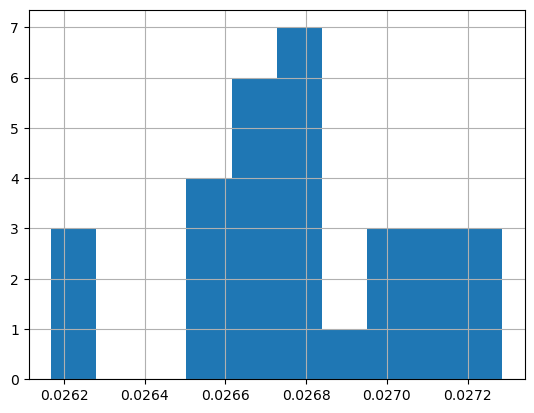

In [360]:
pd.Series(a).hist()

In [474]:
pd.Series(a).min(), pd.Series(a).max(), pd.Series(a).mean() 

(0.0017578387031427917, 0.018956155292497435, 0.006487700023364997)

In [42]:
df=readDataset("dataset/ETTh1.csv")

shape of dataset:  (17420, 8)


In [54]:
df[ (df.OT==0) & (np.abs(df.HULL-3.081)<=0.001)]


date       HUFL   HULL    MUFL   MULL   LUFL   LULL   OT
13738  2018-01-24 10:00:00  11.588000  3.081   7.427  1.777  4.021  1.005  0.0
14396  2018-02-20 20:00:00  18.285999  3.081  12.793  1.315  5.544  0.609  0.0
15457  2018-04-06 01:00:00   8.975000  3.081   6.787  1.812  2.498  0.883  0.0

In [56]:
df[14390:14410]

date       HUFL   HULL    MUFL   MULL   LUFL   LULL  \
14390  2018-02-20 14:00:00  11.186000  1.608   7.285  0.604  3.899  0.548   
14391  2018-02-20 15:00:00  12.056000  1.674   7.889  0.604  4.051  0.579   
14392  2018-02-20 16:00:00  13.999000  2.143   9.630  0.746  4.356  0.548   
14393  2018-02-20 17:00:00  14.334000  2.009   9.772  0.711  4.630  0.548   
14394  2018-02-20 18:00:00  15.271000  2.210  10.518  0.888  4.752  0.548   
14395  2018-02-20 19:00:00  17.549000  2.813  12.189  1.137  5.361  0.579   
14396  2018-02-20 20:00:00  18.285999  3.081  12.793  1.315  5.544  0.609   
14397  2018-02-20 21:00:00  17.415001  2.746  12.260  1.244  5.239  0.609   
14398  2018-02-20 22:00:00  15.807000  2.478  11.122  1.066  4.691  0.548   
14399  2018-02-20 23:00:00  13.932000  2.210   9.879  0.995  3.990  0.518   
14400  2018-02-21 00:00:00  11.521000  1.808   8.280  0.640  3.229  0.548   
14401  2018-02-21 01:00:00   9.712000  1.340   6.929  0.391  2.741  0.487   
14402  2018-02-21 02:00:00   8.707000  1.139   6.254  0.320  2.467  0.426   
14403  2018-02-21 03:00:00   8.306000  1.139   5.899  0.355  2.376  0.457   
14404  2018-02-21 04:00:00   7.837000  0.938   5.579  0.249  2.315  0.396   
14405  2018-02-21 05:00:00   7.904000  0.737   5.579  0.107  2.345  0.366   
14406  2018-02-21 06:00:00   8.372000  0.804   5.757  0.107  2.619  0.366   
14407  2018-02-21 07:00:00  10.985000  1.139   7.462  0.213  3.442  0.426   
14408  2018-02-21 08:00:00  12.860000  1.608   8.777  0.497  4.082  0.457   
14409  2018-02-21 09:00:00   9.042000  1.139   5.686  0.284  3.442  0.487   

          OT  
14390  0.000  
14391  0.633  
14392  0.000  
14393  0.000  
14394  0.000  
14395  0.000  
14396  0.000  
14397  1.899  
14398  2.181  
14399  2.321  
14400  2.532  
14401  2.462  
14402  2.814  
14403  2.462  
14404  2.603  
14405  2.532  
14406  2.462  
14407  2.673  
14408  2.814  
14409  2.744

In [57]:
df.shape

(17420, 8)

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Model(nn.Module):
    """
    Just one Linear layer
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual
        print ("individual flag: ",self.individual) 
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x # [Batch, Output length, Channel]

## yet another test 

In [70]:
dataset_ = "ETTh1.csv"
nhorizion=0.2
df=readDataset(dataset_)


shape of dataset:  (17420, 8)


In [75]:
df[border1s[0]:border2s[0]]

date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0     2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1     2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2     2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3     2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4     2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
...                   ...    ...    ...    ...    ...    ...    ...        ...
8635  2017-06-25 19:00:00  7.770  0.201  4.762  0.675  2.985 -0.640  21.174000
8636  2017-06-25 20:00:00  9.042  0.335  5.650  0.675  3.381 -0.609  20.612000
8637  2017-06-25 21:00:00  8.372  0.536  5.472  0.391  3.290 -0.670  21.034000
8638  2017-06-25 22:00:00  8.975  0.737  6.254  1.031  3.107 -0.579  21.455999
8639  2017-06-25 23:00:00  9.980  1.072  6.610  1.173  2.772 -0.640  20.752001

[8640 rows x 8 columns]

In [76]:
df[border1s[1]:border2s[1]]

date    HUFL   HULL   MUFL   MULL   LUFL   LULL      OT
8304   2017-06-12 00:00:00  10.047  2.210  7.960  2.452  1.919 -0.731  15.336
8305   2017-06-12 01:00:00   9.042  1.808  6.681  1.564  1.828 -0.731  15.054
8306   2017-06-12 02:00:00   9.310  1.875  7.356  2.203  1.736 -0.761  14.280
8307   2017-06-12 03:00:00   8.105  0.938  6.219  1.777  1.949 -0.670  13.858
8308   2017-06-12 04:00:00   8.439  1.474  5.757  1.741  1.919 -0.609  14.210
...                    ...     ...    ...    ...    ...    ...    ...     ...
11515  2017-10-23 19:00:00   8.707  1.005  4.797 -0.604  3.686  1.279  10.271
11516  2017-10-23 20:00:00   8.105  0.938  4.371 -0.569  3.533  1.279   9.708
11517  2017-10-23 21:00:00   7.167  1.206  4.087 -0.462  3.107  1.432   8.723
11518  2017-10-23 22:00:00   7.100  1.340  4.015 -0.320  2.772  1.310   8.864
11519  2017-10-23 23:00:00   9.176  2.746  7.107  1.635  2.650  1.097   9.004

[3216 rows x 8 columns]

In [77]:
df[border1s[2]:border2s[2]]

date       HUFL   HULL    MUFL   MULL   LUFL   LULL  \
11184  2017-10-10 00:00:00  10.717000  4.287   9.417  2.310  1.858  0.944   
11185  2017-10-10 01:00:00  11.855000  4.555  10.056  2.772  1.888  1.310   
11186  2017-10-10 02:00:00  11.788000  4.019   9.417  2.452  1.675  0.914   
11187  2017-10-10 03:00:00  11.454000  3.952   9.452  2.132  1.736  0.944   
11188  2017-10-10 04:00:00  12.726000  4.220   9.808  2.452  2.224  1.127   
...                    ...        ...    ...     ...    ...    ...    ...   
14395  2018-02-20 19:00:00  17.549000  2.813  12.189  1.137  5.361  0.579   
14396  2018-02-20 20:00:00  18.285999  3.081  12.793  1.315  5.544  0.609   
14397  2018-02-20 21:00:00  17.415001  2.746  12.260  1.244  5.239  0.609   
14398  2018-02-20 22:00:00  15.807000  2.478  11.122  1.066  4.691  0.548   
14399  2018-02-20 23:00:00  13.932000  2.210   9.879  0.995  3.990  0.518   

           OT  
11184  14.280  
11185  14.843  
11186  13.999  
11187  14.632  
11188  15.265  
...       ...  
14395   0.000  
14396   0.000  
14397   1.899  
14398   2.181  
14399   2.321  

[3216 rows x 8 columns]

In [192]:
df

date    HUFL   HULL   MUFL   MULL   LUFL   LULL  \
0      2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340   
1      2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371   
2      2016-07-01 02:00:00   5.157  1.741  1.279  0.355  3.777  1.218   
3      2016-07-01 03:00:00   5.090  1.942  1.279  0.391  3.807  1.279   
4      2016-07-01 04:00:00   5.358  1.942  1.492  0.462  3.868  1.279   
...                    ...     ...    ...    ...    ...    ...    ...   
17415  2018-06-26 15:00:00  -1.674  3.550 -5.615  2.132  3.472  1.523   
17416  2018-06-26 16:00:00  -5.492  4.287 -9.132  2.274  3.533  1.675   
17417  2018-06-26 17:00:00   2.813  3.818 -0.817  2.097  3.716  1.523   
17418  2018-06-26 18:00:00   9.243  3.818  5.472  2.097  3.655  1.432   
17419  2018-06-26 19:00:00  10.114  3.550  6.183  1.564  3.716  1.462   

              OT  
0      30.531000  
1      27.787001  
2      27.787001  
3      25.044001  
4      21.948000  
...          ...  
17415  10.904000  
17416  11.044000  
17417  10.271000  
17418   9.778000  
17419   9.567000  

[17420 rows x 8 columns]

#  DLinear Implementation 

In [6]:
## time features

from typing import List

import numpy as np
import pandas as pd 
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5



def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)



def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])


In [44]:
import os
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
#from utils.timefeatures import time_features
import warnings

warnings.filterwarnings('ignore')


class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=False, timeenc=0, freq='h', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        print ("border1, border2, self.features, self.scale, self.timeenc: ", 
        border1, border2, self.features, self.scale, self.timeenc)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        
        print ("self.timeenc: ", self.timeenc)
        
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
        print (len(self.data_x), type(self.data_x), self.data_x.shape)

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        #print ("inside getitem: ",s_begin, s_end, r_begin, r_end)
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [45]:
#from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from torch.utils.data import DataLoader

data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
}


def data_provider(args, flag):
    print ("arguments: ", args)
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != 'timeF' else 1
    train_only = args.train_only

    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = args.freq
        Data = Dataset_Pred
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        train_only=train_only
    )
    print("---------this is in data_factory :", flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        #num_workers=1#args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Model(nn.Module):
    """
    Just one Linear layer
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        print ("self.seq_len, self.pred_len: ",self.seq_len, self.pred_len )
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual
        print ("individual flag: ",self.individual) 
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len) # 336, 96

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            #print ("x shape in forward: ", x.size())
            #print ("x shape after Linear: ", self.Linear(x.permute(0,2,1)).size() )
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x # [Batch, Output length, Channel]

In [47]:

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss



In [48]:
class arguments():
    def __init__(self):
            self.model_id = "ETTh1_336_len_96"
            self.model = "Linear"
            self.data = "ETTh1"
            self.features = "M"
            self.seq_len = 336
            self.label_len =48 ## check this one  
            self.pred_len = 96
            self.d_model = "512"
            self.n_heads ="n_heads"
            self.e_layers ="2" 
            self.d_layers = "1"
            self.d_ff = "2048"
            self.factor ="1" 
            self.embed = "timeF"
            self.distil = ""
            self.des = "Exp"
            self.train_only = False
            self.batch_size = 32
            self.freq = "h"
            self.root_path = "dataset/"
            self.data_path = "ETTh1.csv"
            self.target = "OT"
            self.num_workers = 4
            self.enc_in=1
            self.individual=False

In [49]:
args_ = arguments()

In [50]:
train_data, train_loader=data_provider(args_, flag='train')

arguments:  <__main__.arguments object at 0x7f93f801c160>
border1, border2, self.features, self.scale, self.timeenc:  0 8640 M False 1
self.timeenc:  1
8640 <class 'numpy.ndarray'> (8640, 7)
---------this is in data_factory : train 8209


In [51]:
train_data.__getitem__(0)[3].shape

(144, 4)

In [52]:
import torch.optim as optim

train_steps = len(train_loader)
early_stopping = EarlyStopping(patience=3, verbose=True)

model=Model(args_)
model_optim = optim.Adam(model.parameters() , lr=0.01)
criterion = nn.MSELoss()

self.seq_len, self.pred_len:  336 96
individual flag:  False


In [56]:
for epoch in range(10):
    print ("epoch", epoch)
    iter_count = 0
    train_loss = []

    model.train()
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
        print ("iteration : ",iter_count)
        iter_count += 1
        model_optim.zero_grad()
        print ("calculated grad")
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        
        outputs = model(batch_x)
        
        print ("calculated outputs")
        f_dim = -1 if args_.features == 'MS' else 0
        outputs = outputs[:, -args_.pred_len:, f_dim:]
        batch_y = batch_y[:, -args_.pred_len:, f_dim:]
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()

epoch 0
iteration :  0
calculated grad
calculated outputs
iteration :  1
calculated grad
calculated outputs
iteration :  2
calculated grad
calculated outputs
iteration :  3
calculated grad
calculated outputs
iteration :  4
calculated grad
calculated outputs
iteration :  5
calculated grad
calculated outputs
iteration :  6
calculated grad
calculated outputs
iteration :  7
calculated grad
calculated outputs
iteration :  8
calculated grad
calculated outputs
iteration :  9
calculated grad
calculated outputs
iteration :  10
calculated grad
calculated outputs
iteration :  11
calculated grad
calculated outputs
iteration :  12
calculated grad
calculated outputs
iteration :  13
calculated grad
calculated outputs
iteration :  14
calculated grad
calculated outputs
iteration :  15
calculated grad
calculated outputs
iteration :  16
calculated grad
calculated outputs
iteration :  17
calculated grad
calculated outputs
iteration :  18
calculated grad
calculated outputs
iteration :  19
calculated grad
c

calculated outputs
iteration :  192
calculated grad
calculated outputs
iteration :  193
calculated grad
calculated outputs
iteration :  194
calculated grad
calculated outputs
iteration :  195
calculated grad
calculated outputs
iteration :  196
calculated grad
calculated outputs
iteration :  197
calculated grad
calculated outputs
iteration :  198
calculated grad
calculated outputs
iteration :  199
calculated grad
calculated outputs
iteration :  200
calculated grad
calculated outputs
iteration :  201
calculated grad
calculated outputs
iteration :  202
calculated grad
calculated outputs
iteration :  203
calculated grad
calculated outputs
iteration :  204
calculated grad
calculated outputs
iteration :  205
calculated grad
calculated outputs
iteration :  206
calculated grad
calculated outputs
iteration :  207
calculated grad
calculated outputs
iteration :  208
calculated grad
calculated outputs
iteration :  209
calculated grad
calculated outputs
iteration :  210
calculated grad
calculated o

iteration :  158
calculated grad
calculated outputs
iteration :  159
calculated grad
calculated outputs
iteration :  160
calculated grad
calculated outputs
iteration :  161
calculated grad
calculated outputs
iteration :  162
calculated grad
calculated outputs
iteration :  163
calculated grad
calculated outputs
iteration :  164
calculated grad
calculated outputs
iteration :  165
calculated grad
calculated outputs
iteration :  166
calculated grad
calculated outputs
iteration :  167
calculated grad
calculated outputs
iteration :  168
calculated grad
calculated outputs
iteration :  169
calculated grad
calculated outputs
iteration :  170
calculated grad
calculated outputs
iteration :  171
calculated grad
calculated outputs
iteration :  172
calculated grad
calculated outputs
iteration :  173
calculated grad
calculated outputs
iteration :  174
calculated grad
calculated outputs
iteration :  175
calculated grad
calculated outputs
iteration :  176
calculated grad
calculated outputs
iteration : 

iteration :  110
calculated grad
calculated outputs
iteration :  111
calculated grad
calculated outputs
iteration :  112
calculated grad
calculated outputs
iteration :  113
calculated grad
calculated outputs
iteration :  114
calculated grad
calculated outputs
iteration :  115
calculated grad
calculated outputs
iteration :  116
calculated grad
calculated outputs
iteration :  117
calculated grad
calculated outputs
iteration :  118
calculated grad
calculated outputs
iteration :  119
calculated grad
calculated outputs
iteration :  120
calculated grad
calculated outputs
iteration :  121
calculated grad
calculated outputs
iteration :  122
calculated grad
calculated outputs
iteration :  123
calculated grad
calculated outputs
iteration :  124
calculated grad
calculated outputs
iteration :  125
calculated grad
calculated outputs
iteration :  126
calculated grad
calculated outputs
iteration :  127
calculated grad
calculated outputs
iteration :  128
calculated grad
calculated outputs
iteration : 

iteration :  83
calculated grad
calculated outputs
iteration :  84
calculated grad
calculated outputs
iteration :  85
calculated grad
calculated outputs
iteration :  86
calculated grad
calculated outputs
iteration :  87
calculated grad
calculated outputs
iteration :  88
calculated grad
calculated outputs
iteration :  89
calculated grad
calculated outputs
iteration :  90
calculated grad
calculated outputs
iteration :  91
calculated grad
calculated outputs
iteration :  92
calculated grad
calculated outputs
iteration :  93
calculated grad
calculated outputs
iteration :  94
calculated grad
calculated outputs
iteration :  95
calculated grad
calculated outputs
iteration :  96
calculated grad
calculated outputs
iteration :  97
calculated grad
calculated outputs
iteration :  98
calculated grad
calculated outputs
iteration :  99
calculated grad
calculated outputs
iteration :  100
calculated grad
calculated outputs
iteration :  101
calculated grad
calculated outputs
iteration :  102
calculated g

iteration :  49
calculated grad
calculated outputs
iteration :  50
calculated grad
calculated outputs
iteration :  51
calculated grad
calculated outputs
iteration :  52
calculated grad
calculated outputs
iteration :  53
calculated grad
calculated outputs
iteration :  54
calculated grad
calculated outputs
iteration :  55
calculated grad
calculated outputs
iteration :  56
calculated grad
calculated outputs
iteration :  57
calculated grad
calculated outputs
iteration :  58
calculated grad
calculated outputs
iteration :  59
calculated grad
calculated outputs
iteration :  60
calculated grad
calculated outputs
iteration :  61
calculated grad
calculated outputs
iteration :  62
calculated grad
calculated outputs
iteration :  63
calculated grad
calculated outputs
iteration :  64
calculated grad
calculated outputs
iteration :  65
calculated grad
calculated outputs
iteration :  66
calculated grad
calculated outputs
iteration :  67
calculated grad
calculated outputs
iteration :  68
calculated grad

iteration :  20
calculated grad
calculated outputs
iteration :  21
calculated grad
calculated outputs
iteration :  22
calculated grad
calculated outputs
iteration :  23
calculated grad
calculated outputs
iteration :  24
calculated grad
calculated outputs
iteration :  25
calculated grad
calculated outputs
iteration :  26
calculated grad
calculated outputs
iteration :  27
calculated grad
calculated outputs
iteration :  28
calculated grad
calculated outputs
iteration :  29
calculated grad
calculated outputs
iteration :  30
calculated grad
calculated outputs
iteration :  31
calculated grad
calculated outputs
iteration :  32
calculated grad
calculated outputs
iteration :  33
calculated grad
calculated outputs
iteration :  34
calculated grad
calculated outputs
iteration :  35
calculated grad
calculated outputs
iteration :  36
calculated grad
calculated outputs
iteration :  37
calculated grad
calculated outputs
iteration :  38
calculated grad
calculated outputs
iteration :  39
calculated grad

calculated outputs
iteration :  249
calculated grad
calculated outputs
iteration :  250
calculated grad
calculated outputs
iteration :  251
calculated grad
calculated outputs
iteration :  252
calculated grad
calculated outputs
iteration :  253
calculated grad
calculated outputs
iteration :  254
calculated grad
calculated outputs
iteration :  255
calculated grad
calculated outputs
epoch 6
iteration :  0
calculated grad
calculated outputs
iteration :  1
calculated grad
calculated outputs
iteration :  2
calculated grad
calculated outputs
iteration :  3
calculated grad
calculated outputs
iteration :  4
calculated grad
calculated outputs
iteration :  5
calculated grad
calculated outputs
iteration :  6
calculated grad
calculated outputs
iteration :  7
calculated grad
calculated outputs
iteration :  8
calculated grad
calculated outputs
iteration :  9
calculated grad
calculated outputs
iteration :  10
calculated grad
calculated outputs
iteration :  11
calculated grad
calculated outputs
iterati

calculated outputs
iteration :  213
calculated grad
calculated outputs
iteration :  214
calculated grad
calculated outputs
iteration :  215
calculated grad
calculated outputs
iteration :  216
calculated grad
calculated outputs
iteration :  217
calculated grad
calculated outputs
iteration :  218
calculated grad
calculated outputs
iteration :  219
calculated grad
calculated outputs
iteration :  220
calculated grad
calculated outputs
iteration :  221
calculated grad
calculated outputs
iteration :  222
calculated grad
calculated outputs
iteration :  223
calculated grad
calculated outputs
iteration :  224
calculated grad
calculated outputs
iteration :  225
calculated grad
calculated outputs
iteration :  226
calculated grad
calculated outputs
iteration :  227
calculated grad
calculated outputs
iteration :  228
calculated grad
calculated outputs
iteration :  229
calculated grad
calculated outputs
iteration :  230
calculated grad
calculated outputs
iteration :  231
calculated grad
calculated o

iteration :  174
calculated grad
calculated outputs
iteration :  175
calculated grad
calculated outputs
iteration :  176
calculated grad
calculated outputs
iteration :  177
calculated grad
calculated outputs
iteration :  178
calculated grad
calculated outputs
iteration :  179
calculated grad
calculated outputs
iteration :  180
calculated grad
calculated outputs
iteration :  181
calculated grad
calculated outputs
iteration :  182
calculated grad
calculated outputs
iteration :  183
calculated grad
calculated outputs
iteration :  184
calculated grad
calculated outputs
iteration :  185
calculated grad
calculated outputs
iteration :  186
calculated grad
calculated outputs
iteration :  187
calculated grad
calculated outputs
iteration :  188
calculated grad
calculated outputs
iteration :  189
calculated grad
calculated outputs
iteration :  190
calculated grad
calculated outputs
iteration :  191
calculated grad
calculated outputs
iteration :  192
calculated grad
calculated outputs
iteration : 

calculated outputs
iteration :  139
calculated grad
calculated outputs
iteration :  140
calculated grad
calculated outputs
iteration :  141
calculated grad
calculated outputs
iteration :  142
calculated grad
calculated outputs
iteration :  143
calculated grad
calculated outputs
iteration :  144
calculated grad
calculated outputs
iteration :  145
calculated grad
calculated outputs
iteration :  146
calculated grad
calculated outputs
iteration :  147
calculated grad
calculated outputs
iteration :  148
calculated grad
calculated outputs
iteration :  149
calculated grad
calculated outputs
iteration :  150
calculated grad
calculated outputs
iteration :  151
calculated grad
calculated outputs
iteration :  152
calculated grad
calculated outputs
iteration :  153
calculated grad
calculated outputs
iteration :  154
calculated grad
calculated outputs
iteration :  155
calculated grad
calculated outputs
iteration :  156
calculated grad
calculated outputs
iteration :  157
calculated grad
calculated o

calculated outputs
iteration :  106
calculated grad
calculated outputs
iteration :  107
calculated grad
calculated outputs
iteration :  108
calculated grad
calculated outputs
iteration :  109
calculated grad
calculated outputs
iteration :  110
calculated grad
calculated outputs
iteration :  111
calculated grad
calculated outputs
iteration :  112
calculated grad
calculated outputs
iteration :  113
calculated grad
calculated outputs
iteration :  114
calculated grad
calculated outputs
iteration :  115
calculated grad
calculated outputs
iteration :  116
calculated grad
calculated outputs
iteration :  117
calculated grad
calculated outputs
iteration :  118
calculated grad
calculated outputs
iteration :  119
calculated grad
calculated outputs
iteration :  120
calculated grad
calculated outputs
iteration :  121
calculated grad
calculated outputs
iteration :  122
calculated grad
calculated outputs
iteration :  123
calculated grad
calculated outputs
iteration :  124
calculated grad
calculated o

In [57]:
list(model.parameters())[0].size()

torch.Size([96, 336])

In [59]:
outputs.shape

torch.Size([32, 96, 7])

In [61]:
batch_y.shape

torch.Size([32, 96, 7])

In [62]:
f_dim

0

<AxesSubplot:>

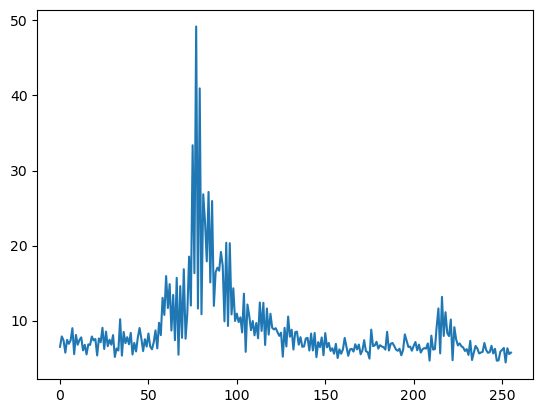

In [65]:
pd.Series(train_loss).plot()